# This file computes diagonalisation & pre-computes results for use later

## Import appropriate modules

In [7]:
import numpy as np
from numpy.linalg import eigh
from numpy import save, savez, savez_compressed
import ast

import diatom.hamiltonian as hamiltonian
import diatom.calculate as calculate
from diatom.constants import *

import scipy.constants
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh

## Defining parameters

In [121]:
MOLECULE_STRING = "Rb87Cs133"
MOLECULE = Rb87Cs133
N_MAX=1
PULSE_TIME_US = 500 #μs

GAUSS = 1e-4 # T
B = np.concatenate([np.arange(0.1,100,0.1),np.arange(100,500,1),np.arange(500,1000,10)]) * GAUSS

######

B_STEPS = len(B)
B_MIN = B[0]
B_MAX= B[-1]

settings_string = f'{MOLECULE_STRING}NMax{N_MAX}PTime{PULSE_TIME_US}'

H_BAR = scipy.constants.hbar

I1 = MOLECULE["I1"]
I2 = MOLECULE["I2"]
I1_D = round(2*MOLECULE["I1"])
I2_D = round(2*MOLECULE["I2"])

PER_MN = (I1_D+1)*(I2_D+1)
N_STATES = PER_MN * (N_MAX+1)**2

PULSE_TIME = PULSE_TIME_US * 1e-6 # s

## Diagonalise & Calculate 

In [122]:
H0,Hz,Hdc,Hac = hamiltonian.build_hamiltonians(N_MAX, MOLECULE, zeeman=True, Edc=False, ac=False)

H = (
    +H0[..., None]
    +Hz[..., None]*B
    # +Hdc[..., None]*E
    # +Hac[..., None]*I
    )
H = H.transpose(2,0,1)
# H_SPARSE = csr_matrix(H[0])

In [33]:
%%time
# y=eigsh(H_SPARSE,k=N_STATES-2)

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 12.9 µs


In [38]:
%%time
x=eigh(H[0:200])
print(B_STEPS)

1449
CPU times: user 2min 28s, sys: 8.61 s, total: 2min 36s
Wall time: 21.1 s


In [148]:
# %%time
ENERGIES_UNSORTED, STATES_UNSORTED = eigh(H)

In [143]:
ENERGIES_HALF_SORTED, STATES_HALF_SORTED = calculate.sort_smooth(ENERGIES_UNSORTED,STATES_UNSORTED)

In [156]:
ENERGIES, STATES, labels_d = calculate.sort_by_state(ENERGIES_HALF_SORTED, STATES_HALF_SORTED, N_MAX, MOLECULE)
# ENERGIES, STATES, labels_d = calculate.sort_by_state(ENERGIES_UNSORTED, STATES_UNSORTED, N_MAX, MOLECULE)

In [157]:
labels_d[:,1] *= 2 # Double MF to guarantee int
LABELS_D=(np.rint(labels_d)).astype("int")

In [158]:
LABELS_D

array([[  0,   4,   0],
       [  0,   2,   0],
       [  0,   0,   0],
       [  0,  -2,   0],
       [  0,  -4,   0],
       [  0,   6,   0],
       [  0,   4,   1],
       [  0,   2,   1],
       [  0,   0,   1],
       [  0,  -2,   1],
       [  0,  -4,   1],
       [  0,  -6,   0],
       [  0,   8,   0],
       [  0,   6,   1],
       [  0,   4,   2],
       [  0,   2,   2],
       [  0,   0,   2],
       [  0,  -2,   2],
       [  0,  -4,   2],
       [  0,  -6,   1],
       [  0,  -8,   0],
       [  0,  10,   0],
       [  0,   8,   1],
       [  0,   6,   2],
       [  0,   4,   3],
       [  0,   2,   3],
       [  0,   0,   3],
       [  0,  -2,   3],
       [  0,  -4,   3],
       [  0,  -6,   2],
       [  0,  -8,   1],
       [  0, -10,   0],
       [  1,   4,   0],
       [  1,   2,   0],
       [  1,   0,   0],
       [  1,  -2,   0],
       [  1,  -4,   0],
       [  1,   6,   0],
       [  1,   4,   1],
       [  1,   2,   1],
       [  1,   0,   1],
       [  1,  -2

In [127]:
UNCOUPLED_LABELS_D = []

for n in range(0, N_MAX + 1):
    for mn in range(n,-(n+1),-1):
        for mi1d in range(I1_D,-I1_D-1,-2):
            for mi2d in range(I2_D,-I2_D-1,-2):
                UNCOUPLED_LABELS_D.append((n,mn,mi1d,mi2d))

UNCOUPLED_LABELS_D = (np.rint(UNCOUPLED_LABELS_D)).astype("int")

In [128]:
MAGNETIC_MOMENTS = np.einsum('bji,jk,bki->bi', STATES.conj(), -Hz, STATES, optimize='optimal')

In [129]:
dipole_op_zero = calculate.dipole(N_MAX,I1,I2,1,0)
dipole_op_minus = calculate.dipole(N_MAX,I1,I2,1,-1)
dipole_op_plus = calculate.dipole(N_MAX,I1,I2,1,+1)

# Helper Functions

In [130]:
def label_to_state_no(N,MF_D,k):
    return np.where((LABELS_D[:, 0] == N) & (LABELS_D[:, 1] == MF_D) & (LABELS_D[:, 2] == k))[0][0]

def state_no_to_uncoupled_label(state_no):
    return UNCOUPLED_LABELS_D[state_no]

In [131]:
def label_d_to_string(label_d):
    n = label_d[0]
    mf_d = label_d[1]
    mf_frac = mf_d%2
    i = label_d[2]
    if mf_frac == 0:
        return f"({n},{mf_d//2},{i})"
    else:
        mf_whole= (mf_d - np.sign(mf_d))//2
        return f"({n},{mf_whole}.5,{i})"

def label_d_to_latex_string(label_d):
    n = label_d[0]
    mf_d = label_d[1]
    mf_frac = mf_d%2
    i = label_d[2]
    if mf_frac == 0:
        return r'|{},{}\rangle_{{{}}}'.format(n,mf_d//2,i)
    else:
        mf_whole= (mf_d - np.sign(mf_d))//2
        return r'|{},{}.5\rangle_{{{}}}'.format(n,mf_whole,i)

In [132]:
def label_degeneracy(N,MF_D):
    # Want number of ways of having
    # MF = MN + (M_I1 + M_I2) # NP-Hard Problem SSP (Subset Sum)
    d=0
    for MN in range(-N,N+1):
        for M_I1_D in range(-I1_D,I1_D+1,2):
            for M_I2_D in range(-I2_D,I2_D+1,2):
                if 2*MN+M_I1_D+M_I2_D == MF_D:
                    d+=1
    return d

In [133]:
def reachable_above_from(N,MF_D):
    sigma_plus_reachable = [(N+1,MF_D-2,i) for i in range(label_degeneracy(N+1,MF_D-2))]
    pi_reachable = [(N+1,MF_D,i) for i in range(label_degeneracy(N+1,MF_D))]
    sigma_minus_reachable = [(N+1,MF_D+2,i) for i in range(label_degeneracy(N+1,MF_D+2))]
    return (sigma_plus_reachable + pi_reachable + sigma_minus_reachable)

def twice_average_fidelity(k,g):
    return ((1 + g**2)**2 + 8*k**2*(-1 + 2*g**2) + 16*k**4)/((1 + g**2)**3 + (-8 + 20*g**2 + g**4)*k**2 + 16*k**4)

def maximum_fidelity(k,g):
    phi = np.arccos((k*(18-9*g**2-8*k**2))/(3+3*g**2+4*k**2)**(3/2))/3
    denominator = 54*((1+g**2)**3+(-8+20*g**2+g**4)*k**2+16*k**4)
    numerator = (
                 36*(g**4+(1-4*k**2)**2+2*g**2*(1+8*k**2))
               + 32*k    *(3+3*g**2+4*k**2)**(3/2) *np.cos(phi)
               - 64*k**2 *(3+3*g**2+4*k**2)        *np.cos(2*phi) 
               -  4      *(3+3*g**2+4*k**2)**2     *np.cos(4*phi)
                )
    return numerator/denominator

def fidelity(ts,d=8):
    return -np.log10(1-ts+10**(-d))

In [134]:
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

def field_to_bi(gauss):
    return find_nearest(B,gauss*GAUSS)

In [135]:
def fid_to_string(fid):
    return f"{fid:.4f}({fidelity(fid,d=9):.1f})"

# Generate labels

In [136]:
generated_labels = []
state_jump_list = []
n=0
for N in range(N_MAX+1):
    F_D = 2*N + I1_D + I2_D
    sub_jump_list = []
    for MF_D in range(-F_D,F_D+1,2):
        sub_jump_list.append(n)
        for d in range(label_degeneracy(N,MF_D)):
            generated_labels.append((N,MF_D,d))
            n+=1
    state_jump_list.append(sub_jump_list)
            
        
def label_d_to_node_index(N,MF_D,d):
    return state_jump_list[N][(2*N + I1_D + I2_D + MF_D)//2]+d
            
label_d_to_node_index(0,2,3)

21

In [137]:
generated_edges = []
edge_jump_list = []
n=0
for N,MF_D,d in generated_labels:
    sub_jump_list = []
    sub_jump_list.append(len(generated_edges))
    if N>0:
        down_F_D = 2*(N-1) + I1_D + I2_D
    # add P=0
    if N<N_MAX:
        generated_edges += [(N,MF_D,d,N+1,MF_D,i) for i in range(label_degeneracy(N+1,MF_D))]
    if N>0:
        generated_edges += [(N,MF_D,d,N-1,MF_D,i) for i in range(label_degeneracy(N-1,MF_D))]
    sub_jump_list.append(len(generated_edges))
    # add P=1
    if N<N_MAX:
        generated_edges += [(N,MF_D,d,N+1,MF_D-2,i) for i in range(label_degeneracy(N+1,MF_D-2))]
    if N>0 and MF_D+2 <= down_F_D:
        generated_edges += [(N,MF_D,d,N-1,MF_D+2,i) for i in range(label_degeneracy(N-1,MF_D+2))]
    sub_jump_list.append(len(generated_edges))
    # add P=-1
    if N<N_MAX:
        generated_edges += [(N,MF_D,d,N+1,MF_D+2,i) for i in range(label_degeneracy(N+1,MF_D+2))]
    if N>0 and MF_D-2 >= -down_F_D:
        generated_edges += [(N,MF_D,d,N-1,MF_D-2,i) for i in range(label_degeneracy(N-1,MF_D-2))]
    sub_jump_list.append(len(generated_edges))
    edge_jump_list.append(sub_jump_list)
    
def label_d_to_edge_indices(N,MF_D,d): # Returns the start indices of P=0,P=1,P=2, and the next edge
    return edge_jump_list[label_d_to_node_index(N,MF_D,d)]


In [58]:
COUPLINGS_ZERO = STATES[:, :, :].conj().transpose(0, 2, 1) @ dipole_op_zero @ STATES[:, :, :]
COUPLINGS_MINUS = STATES[:, :, :].conj().transpose(0, 2, 1) @ dipole_op_minus @ STATES[:, :, :]
COUPLINGS_PLUS = STATES[:, :, :].conj().transpose(0, 2, 1) @ dipole_op_plus @ STATES[:, :, :]
COUPLINGS_UNPOLARISED = COUPLINGS_ZERO + COUPLINGS_MINUS + COUPLINGS_PLUS

In [94]:
COUPLINGS_SPARSE = np.zeros((len(generated_edges),B_STEPS),dtype=np.double)
COUPLINGS_SPARSE.shape

(29300, 1449)

In [95]:
from tqdm import tqdm

for N,MF_D,d in tqdm(LABELS_D):
    edge_indices = label_d_to_edge_indices(N,MF_D,d)
    from_label_index = label_to_state_no(N,MF_D,d)

    label_d_pairs = generated_edges[edge_indices[0]:edge_indices[1]]
    if not label_d_pairs:
        continue
    pol_zero_needed_to_indices = np.array([label_to_state_no(N,MF,d) for _,_,_,N,MF,d in label_d_pairs])
    COUPLINGS_SPARSE[edge_indices[0]:edge_indices[1],:] = COUPLINGS_ZERO[:,from_label_index,pol_zero_needed_to_indices].T#np.einsum('bi,ij,bnj->nb',STATES[:, from_label_index, :].conj(), dipole_op_zero, STATES[:, pol_zero_needed_to_indices, :])

  0%|                                                                                                                                                                                                         | 0/512 [00:00<?, ?it/s]/var/folders/lt/2lfqhmyn1n9bbwg1sqf3zzwc0000gn/T/ipykernel_48443/3511810009.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  COUPLINGS_SPARSE[edge_indices[0]:edge_indices[1],:] = COUPLINGS_ZERO[:,from_label_index,pol_zero_needed_to_indices].T#np.einsum('bi,ij,bnj->nb',STATES[:, from_label_index, :].conj(), dipole_op_zero, STATES[:, pol_zero_needed_to_indices, :])
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:03<00:00, 134.77it/s]


In [93]:
COUPLINGS_SPARSE[edge_indices[0]:edge_indices[1],:].shape

(0, 1449)

In [96]:
COUPLINGS_SPARSE.shape

(29300, 1449)

In [138]:
LABELS_D.shape

(128, 3)

In [91]:
edge_indices[0],edge_indices[1]

(29277, 29280)

In [87]:
label_d_to_node_index(N,MF_D,d)

print(edge_jump_list[label_d_to_node_index(N,MF_D,d)])
generated_edges[29299:29300]

[29299, 29299, 29299, 29300]


[(3, 16, 0, 2, 14, 0)]

In [171]:
for _,_,_,N,MF,d in label_d_pairs:
    print(N,MF,d)
    label_to_state_no(N,MF,d) 

3 2 0


IndexError: index 0 is out of bounds for axis 0 with size 0

In [101]:
edge_indices = label_d_to_edge_indices(0,8,1)
test = COUPLINGS_SPARSE[edge_indices[0]:edge_indices[1],:]


In [102]:
test.shape

(6, 1449)

In [113]:
labels_d.shape

(512, 3)

In [105]:
np.array(generated_labels).shape

(512, 3)

In [141]:
LABELS_D[0,:]

array([0, 4, 0])

In [140]:
energy_to_canonical_map = []
for label in LABELS_D:
    energy_to_canonical_map.append(label_d_to_node_index(*label))
energy_to_canonical_map = np.array(energy_to_canonical_map)

In [159]:
energy_to_canonical_map[0]

22

In [160]:
generated_labels[22]

(0, 4, 0)

In [161]:
ENERGIES_CANONICAL_ORDER = ENERGIES[:,energy_to_canonical_map]

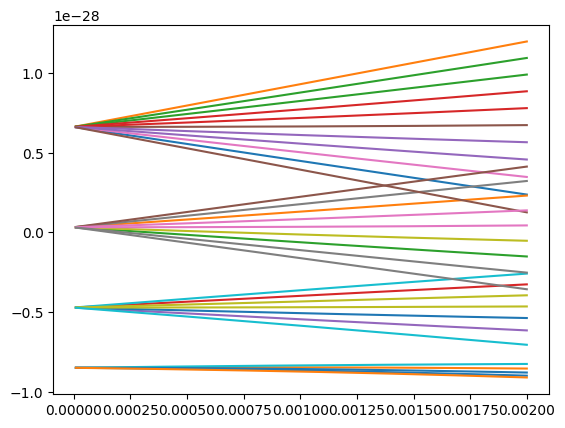

In [181]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()

ax.plot(B[0:200],ENERGIES_CANONICAL_ORDER[0:200,0:32])